# Behaviourial cloning project

The aim of the present project is to predict the steering angle to be applied on a car using images generated by a front facing camera. For this purpose, this image is fed as an input to a deep convolutional network, followed by several fully connected layers and resulting in the final normalized steering command. This project is called behaviourial cloning, since this model is trained on data acquired on a real vehicle and driven by a real person. Hence, the model tries to copy the natural driving behaviour of a driver.

In [1]:
# General
import numpy as np
import matplotlib.pyplot as plt
import csv
import os
import json
import random

# Keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda
from keras.layers.convolutional import Convolution2D
from keras.optimizers import Adam

# Image
from skimage import io
from skimage import util
from skimage import exposure
from skimage import transform
import cv2

Using TensorFlow backend.


## Import data

In [2]:
# Import data
path = 'data/driving_log.csv'

# List initialisation   
center_path = []
left_path   = []
right_path  = []
steering    = []
throttle    = []
brake       = []
speed       = []

# Read file
with open(path) as f:
    
    # Skip headers
    f.readline()
    
    # Extract info from CSV
    csv_reader = csv.reader(f)
    for line in csv_reader:
        center_path.append(line[0])
        left_path.append(line[1])
        right_path.append(line[2])
        steering.append(float(line[3]))
        throttle.append(float(line[4]))
        brake.append(float(line[5]))
        speed.append(float(line[6]))
        
print('Data imported !')

Data imported !


## Data exploration

Number of data samples =  8036
Maximum steering angle =  1.0
Minimum steering angle =  -0.9426954


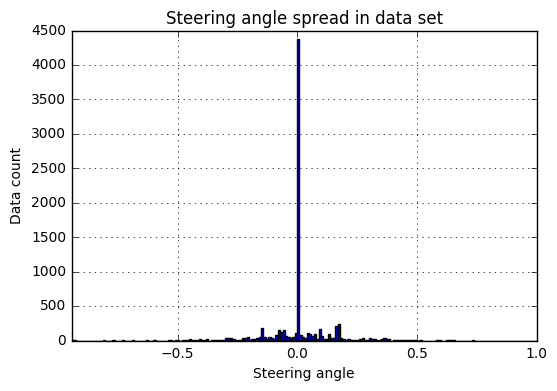

In [3]:
# Number of data samples
n_data = len(center_path)
print('Number of data samples = ', n_data)

# Steering angle extrema
steer_max = max(steering)
steer_min = min(steering)
print('Maximum steering angle = ', steer_max)
print('Minimum steering angle = ', steer_min)

# Steering angle histogram
bin_size = 0.01
bin_n = np.ceil((steer_max - steer_min)/bin_size)
bins = np.zeros((bin_n.astype(int)))

for angle in steering:
    n = np.floor((angle - steer_min)/bin_size)
    bins[n.astype(int)] += 1
    
plt.bar(np.linspace(steer_min, steer_max, bin_n),bins, bin_size)
plt.xlabel('Steering angle')
plt.ylabel('Data count')
plt.title('Steering angle spread in data set')
plt.grid()
plt.xlim([steer_min, steer_max])
plt.show()

In [4]:
def plot_images(images):

    title = ('Left', 'Center', 'Right')
    f, axarr = plt.subplots(1, 3, figsize = (10,2))

    for i, ax in enumerate(axarr):
        ax.imshow(images[i])
        ax.set_yticks([])
        ax.set_xticks([])
        ax.set_title(title[i])

    plt.show()

Size of the images =  (160, 320, 3)


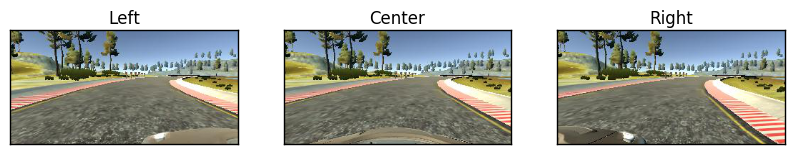

In [5]:
# Import image
path = 'data/'
n    = random.randint(0, n_data)

center = io.imread(path + center_path[n])
left   = io.imread(path + left_path[n].strip())
right  = io.imread(path + right_path[n].strip())

# Image size
print('Size of the images = ', center.shape)

# Plot images
images = np.array((left, center, right))
plot_images(images)

## Data augmentation and pre-processing

### Cropping

In [6]:
def crop_images(images, shape):
    left, top, right, bottom = shape
    crop_width = ((0, 0),
                  (top, bottom),
                  (left, right),
                  (0, 0))
    return util.crop(images, crop_width)

Image size after croppping =  (110, 320, 3)


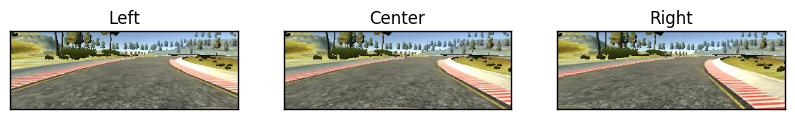

In [7]:
# Crop images
cropped_images = crop_images(images, (0, 30, 0, 20))
print('Image size after croppping = ', cropped_images[0].shape)
plot_images(cropped_images)

### Exposure variation

In [8]:
def exposure_variation(images, bounds = (0.6, 1.0)):
    gain = random.uniform(bounds[0], bounds[1])
    out_images = np.zeros(images.shape)
    for i in range(images.shape[0]):
        exposure_flag = np.random.randint(2)
        if exposure_flag == 0:
            image_hsv = cv2.cvtColor(images[i], cv2.COLOR_RGB2HSV)
            image_hsv[:,:,2] = image_hsv[:,:,2]*gain
            out_images[i] = cv2.cvtColor(image_hsv, cv2.COLOR_HSV2RGB)
        else:
            out_images[i] = images[i];
    return out_images.astype(np.uint8)

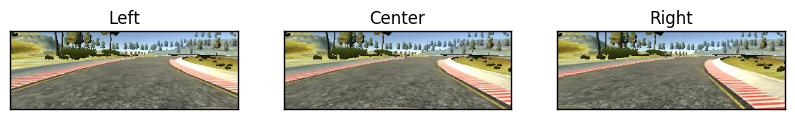

In [9]:
# Exposure
exp_images = exposure_variation(cropped_images)
plot_images(exp_images)

### Conversion to YUV

In [10]:
def to_YUV(images):
    out_images = np.zeros(images.shape)
    for i in range(images.shape[0]):
        out_images[i] = cv2.cvtColor(images[i], cv2.COLOR_RGB2YUV)
    return out_images

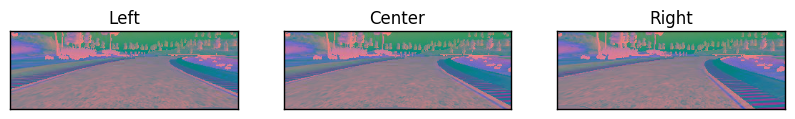

In [11]:
# YUV transformation
yuv_images = to_YUV(exp_images)
plot_images(yuv_images)

### Change of POV

In [12]:
def fast_warp(image_data, transf, mode = 'edge'):
    """Proposed by Florian muellerklein"""
    out_shape = image_data.shape
    return transform._warps_cy._warp_fast(image_data,  transf.params, output_shape = out_shape, mode = mode)

In [13]:
def transformation(image_in, trans, rot):
    
    image = np.copy(image_in)
    
    width_pixel = images.shape[2]
    height_pixel = images.shape[1]
    
    horizon = 100
    
    ground = image[height_pixel-horizon:height_pixel,: ,:]
    sky    = image[0:height_pixel-horizon, :, :]
    
    src = np.array(((0, 0),
                    (0, horizon),
                    (width_pixel, horizon),
                    (width_pixel, 0)))
    
    width_real = 6
    pixel_per_meter = width_pixel/width_real
    
    translation_pixel = pixel_per_meter*trans
    rotation_pixel = 4*np.sin(rot)*horizon
    
    dst = np.array(((min([0, rotation_pixel]), 0),
                    (min([0, translation_pixel]), horizon),
                    (max([width_pixel,width_pixel+translation_pixel]), horizon),
                    (max([width_pixel,width_pixel+rotation_pixel]), 0)))
    
    transf = transform.ProjectiveTransform()
    transf.estimate(dst, src)
    ground_dist = transform.warp(ground, transf, order = 1, mode = 'edge') 
    X = np.vstack((sky/255, ground_dist))*255
    return X.astype(np.uint8)

--- Translation modifier =  -1.5  [m] ---


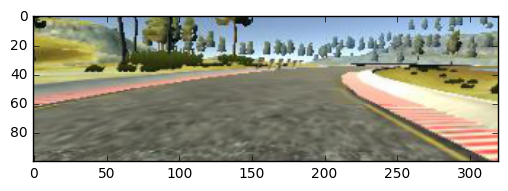

--- Translation modifier =  -0.75  [m] ---


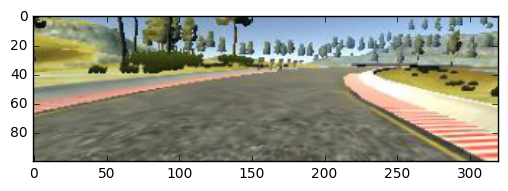

--- Translation modifier =  0.0  [m] ---


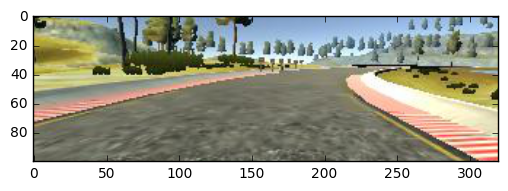

--- Translation modifier =  0.75  [m] ---


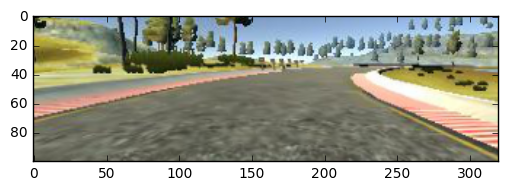

--- Translation modifier =  1.5  [m] ---


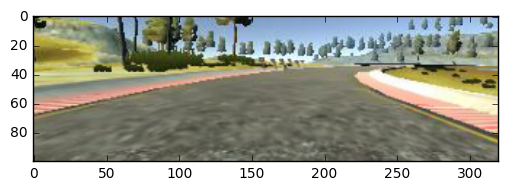

In [14]:
for trans in np.linspace(-1.5,1.5,5):
    print("--- Translation modifier = ",trans,' [m] ---')
    pov_images = transformation(images[1],trans,0)
    pov_images = crop_images(pov_images.reshape(1,160,320,3), (0, 30, 0, 30))
    plt.imshow(pov_images.reshape(100,320,3))
    plt.show()

--- Rotation modifier =  -45.0  [deg] ---


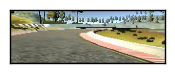

--- Rotation modifier =  -22.5  [deg] ---


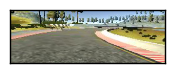

--- Rotation modifier =  0.0  [deg] ---


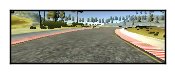

--- Rotation modifier =  22.5  [deg] ---


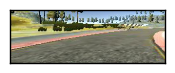

--- Rotation modifier =  45.0  [deg] ---


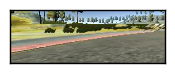

In [15]:
for rot in np.linspace(-np.pi/4,np.pi/4,5):
    print("--- Rotation modifier = ",rot*180/np.pi,' [deg] ---')
    pov_images = transformation(images[1],0,rot)
    pov_images = crop_images(pov_images.reshape(1,160,320,3), (0, 30, 0, 20))
    f = plt.figure(figsize=(2,3))
    ax = f.add_subplot(111)
    ax.imshow(pov_images.reshape(110,320,3))
    ax.set_yticks([])
    ax.set_xticks([])
    plt.show()

In [16]:
def shadow(images, bounds = (0.5, 0.8)):
    
    # Variable initialisation
    out_images = np.zeros(images.shape)
    
    # Loop over all provided images
    for i in range(images.shape[0]):
        rows = images.shape[1]
        cols = images.shape[2]
        top_x, bottom_x = np.random.randint(0,cols, 2)
        
        # Proability to cast a shadow = 1/2
        shadow_flag = np.random.randint(2)
        if shadow_flag == 0:

            # Two shadow modes
            rand = np.random.randint(2)
                        
            # Shadow from the left
            if rand == 0:
                vertices = np.array([[top_x, 0], [0, 0], [0, rows], [bottom_x, rows]], dtype=np.int32)
            # Shadow from the right
            elif rand == 1:
                vertices = np.array([[top_x, 0], [cols, 0], [cols, rows], [bottom_x, rows]], dtype=np.int32)
            
            # Mask shadow
            mask = images[i].copy()
            ignore_mask_color = (0,) * 3
            cv2.fillPoly(mask, [vertices], ignore_mask_color)
            
            # Add shadow to image
            alpha = random.uniform(bounds[0], bounds[1])
            out_images[i] = cv2.addWeighted(mask, alpha, images[i], 1 - alpha, 0.)
            
        # No shadow
        else:
            out_images[i] = images[i]
        
    return out_images.astype(np.uint8)

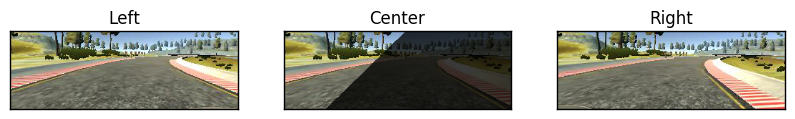

In [17]:
# Shadow cast
shadow_images = shadow(exp_images)
plot_images(shadow_images)

In [18]:
def flip(imges):
    return images[:,:,::-1,:]

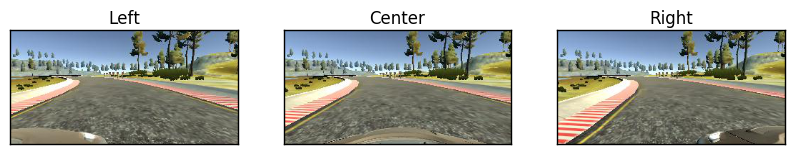

In [19]:
# Flip
flip_images = flip(exp_images)
plot_images(flip_images)

In [20]:
def data_augmentation(X, y, aug):
    
    X_aug = np.zeros(X.shape)
    X_out = np.zeros((X.shape[0], 66, 200, 3))
    y_aug = np.zeros(y.shape)
    dTheta = np.pi/4
    
    if aug == True:
        for i in range(X_aug.shape[0]):
            rotation = np.random.normal(0,dTheta)

            # Random rotation
            X_aug[i,:,:,:] = transformation(X[i],0,rotation)
            y_aug[i] = y[i] + rotation*0.2/dTheta

        # Cropping
        X_aug = crop_images(X_aug, (0, 45, 0, 20))

        # Exposure variation
        X_aug = exposure_variation(X_aug.astype(np.uint8))

        # Shadowing
        X_aug = shadow(X_aug)
    
    # By-pass augmentation
    else:
        X_aug = X
        
    # Scaling
    for i in range(X_aug.shape[0]):
        X_out[i] = cv2.resize(X_aug[i,:,:,:], (200, 66), cv2.INTER_AREA)

    return X_out, y_aug

In [21]:
index = list(range(6*n_data))
random.shuffle(index)
split = 0
ind_train = index[0:np.floor(len(index)*(1-split)).astype(int)] 
ind_test  = index[np.ceil(len(index)*(1-split)).astype(int):len(index)] 
print(len(ind_train))

48216


In [22]:
def load_data(ind):
    n_batch = len(ind)
    X = np.zeros((n_batch, center.shape[0], center.shape[1], center.shape[2]), dtype = np.uint8)
    y = np.zeros(n_batch)

    offset = 0.22

    for i in range(n_batch):
        # Check if flipping or not
        flip = False
        if ind[i] >= 3*n_data:
            ind[i] = ind[i] - 3*n_data
            flip = True
            
        # Check camera position
        if ind[i] < n_data:
            image = io.imread(path + center_path[ind[i]])
            steer = steering[ind[i]]
        elif n_data <= ind[i] < 2*n_data:
            image = io.imread(path + left_path[ind[i]%n_data].strip())
            steer = steering[ind[i]%n_data] + offset
        else:
            image = io.imread(path + right_path[ind[i]%(2*n_data)].strip())
            steer = steering[ind[i]%(2*n_data)] - offset
        
        # Flipping
        if flip == True:
            image = image[:,::-1,:]
            steer = -steer
            
        X[i,:,:,:] = image
        y[i] = steer
    return X,y

In [23]:
X_train, y_train = load_data([ind_train[0]])
print(X_train.shape)
print(y_train.shape)

(1, 160, 320, 3)
(1,)


### Fit generator

In [24]:
# Keras generator
def gen(batch_size, aug = True):
    while 1:
        random.shuffle(ind_train)
        for offset in range(0, len(ind_train), batch_size):
            batch_X, batch_y = load_data(ind_train[offset:offset+batch_size])
            X_aug, y_aug = data_augmentation(batch_X, batch_y, aug)
            yield (X_aug, y_aug)

## Model generation

The proposed architecture follows the implementation used by NVIDIA in their end-to-end deep learning paper on behaviourial cloning. 
<img src="architecture.png" />

In [25]:
# Keras model
def model_init():
    
    # Input format
    channels  = 3
    height    = 66
    width     = 200
    keep_prob = 0.5
    
    model = Sequential()
    
    # Normalisation layer
    model.add(Lambda(lambda x: x/127.5 - 1.,
              input_shape=(height, width, channels),
              output_shape=(height, width, channels)))
    # Convolution Kernel : 5x5 - Stride :  2x2 - Depth : 24
    model.add(Convolution2D(24, 5, 5, 
                            subsample=(2, 2), 
                            border_mode="valid", 
                            activation = "relu"))
    # Convolution Kernel : 5x5 - Stride :  2x2 - Depth : 36
    model.add(Convolution2D(36, 5, 5, 
                            subsample=(2, 2), 
                            border_mode="valid", 
                            activation = "relu"))      
    # Convolution Kernel : 5x5 - Stride :  2x2 - Depth : 48
    model.add(Convolution2D(48, 5, 5, 
                            subsample=(2, 2), 
                            border_mode="valid", 
                            activation = "relu"))        
    # Convolution Kernel : 3x3 - Stride :  1x1 - Depth : 64
    model.add(Convolution2D(64, 3, 3, 
                            subsample=(1, 1), 
                            border_mode="valid", 
                            activation = "relu"))
    # Convolution Kernel : 3x3 - Stride :  1x1 - Depth : 64
    model.add(Convolution2D(64, 3, 3, 
                            subsample=(1, 1), 
                            border_mode="valid", 
                            activation = "relu"))          
    # Flatten Output : 1164
    model.add(Flatten())
    model.add(Dropout(.5))
    # Fully connected Output : 100
    model.add(Dense(100,
                    activation = "relu"))
    model.add(Dropout(.5))
    # Fully connected Output : 50
    model.add(Dense(50,
                    activation = "relu"))
    model.add(Dropout(.5))
    # Fully connected Output : 10
    model.add(Dense(10,
                    activation = "relu"))
    # Fully connected Output : 1
    model.add(Dense(1))
    # Compile model
    adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer=adam, loss='mse')

    return model

model = model_init()
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 66, 200, 3)    0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 31, 98, 24)    1824        lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 14, 47, 36)    21636       convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_3 (Convolution2D)  (None, 5, 22, 48)     43248       convolution2d_2[0][0]            
___________________________________________________________________________________________

## Model training

<img src="training.png" />

In [67]:
# Model training
epochs = 2
batch_size = 128
batches_train = 200

out = model.fit_generator(
                    gen(batch_size, aug = True),
                    samples_per_epoch = batches_train*batch_size,
                    nb_epoch = epochs)

#,
#    validation_data = gen(batch_size, data_path, split = 0.2, mode = 'valid'),
#    nb_val_samples=batches_validate*bach_size

Epoch 1/2
25600/25600 [==============================] - 409s - loss: 0.0286     

C:\Program Files\Miniconda3\envs\carnd-term1\lib\site-packages\keras\engine\training.py:1537: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


In [27]:
X=gen(5000)# Model evaluation
steer = next(X)[1]
image = next(X)[0]
#help(model.fit)
steer_max = np.max(steer)
steer_min = np.min(steer)
# Steering angle histogram
bins = np.zeros((bin_n.astype(int)))

for angle in steer:
    n = np.floor((angle - steer_min)/bin_size)
    bins[n.astype(int)] += 1
    
plt.bar(np.linspace(steer_min, steer_max, bin_n),bins, bin_size)
plt.xlabel('Steering angle')
plt.ylabel('Data count')
plt.title('Steering angle spread in data set')
plt.grid()
plt.xlim([steer_min, steer_max])
plt.show()
#model.evaluate(x, y, batch_size=32)

plt.figure(figsize=(12,6))
for i in range(60):
    
    plt.subplot(6,10,i+1)
    plt.imshow(image[i,:,:,:].astype(np.uint8));
    plt.axis('off')
    plt.text(0,-10,'y_t = '+str(steer[i])[:5])
    y_pred = float(model.predict(image[i].reshape((1,66,200,3)), batch_size=1))
    plt.text(0,100,'y_p = '+str(y_pred)[:5])
plt.show()

IndexError: index 198 is out of bounds for axis 0 with size 195

In [71]:
# Model saving
if not os.path.exists("./outputs/steering_model"):
    os.makedirs("./outputs/steering_model")

model.save_weights("./outputs/steering_model/steering_angle.keras", True)
model.save('steering_angle.h5') 
with open('./outputs/steering_model/steering_angle.json', 'w') as outfile:
    json.dump(model.to_json(), outfile)